# SigLIP-Based Multimodal Learning for Skin Condition and Herbal Treatment Alignment

**Academic Research Project**: Vision-Language Model Implementation for Medical Image-Text Retrieval

**Institutional Context**: Graduate-level research utilizing state-of-the-art multimodal transformers

**Objective**: Implement a complete SigLIP multimodal learning pipeline to align dermatological condition images with herbal treatment descriptions using contrastive learning methodologies

**Dataset Sources**:
- `skincon_preprocessed.csv`: Dermatological condition metadata with image filenames
- `herb2_final_clean.csv`: Medicinal plant compound information and therapeutic functions
- Image directory: `/kaggle/input/siglipdataset/images-20251125T090951Z-1-001`

**Model Architecture**: Google SigLIP (Sigmoid Loss for Language-Image Pre-training)

**Evaluation Scope**: Skin and Connective Tissue Diseases exclusively

## Academic Background and Related Work

**Vision-Language Models in Medical Applications**

Multimodal learning frameworks have demonstrated substantial efficacy in aligning visual and textual modalities through contrastive learning objectives. The CLIP architecture (Radford et al., 2021) introduced large-scale vision-language pre-training using contrastive objectives, establishing foundational methodologies for cross-modal retrieval tasks. Building upon this framework, SigLIP (Zhai et al., 2023) proposed sigmoid loss for language-image pre-training, addressing limitations in traditional softmax-based contrastive learning by enabling more efficient pairwise optimization and improving scaling properties.

**Theoretical Foundation**

SigLIP employs a pairwise sigmoid loss function rather than the standard InfoNCE loss utilized in CLIP. The sigmoid formulation $\mathcal{L}_{\text{SigLIP}} = -\sum_{i,j} \log \sigma(z_i^T z_j \cdot y_{ij})$ where $y_{ij} \in \{-1, +1\}$ indicates positive or negative pairs, enables independent optimization of each image-text pair without requiring global normalization across batch samples. This architectural modification yields superior performance on retrieval benchmarks while maintaining computational efficiency.

**Medical Domain Applications**

Recent research has explored vision-language models for medical imaging tasks, including dermatological diagnosis (Daneshjou et al., 2022), radiology report generation (Chen et al., 2023), and pathology image analysis (Lu et al., 2023). The integration of traditional herbal medicine knowledge with modern computational approaches represents an emerging interdisciplinary research direction, combining ethnobotanical databases with deep learning methodologies.

**Research Objectives**

This implementation evaluates SigLIP performance on a specialized medical retrieval task: matching dermatological condition images with corresponding herbal treatment descriptions. The pipeline incorporates proper train-test stratification, comprehensive evaluation metrics, and systematic analysis of retrieval quality across disease categories.

**References**:
- Radford, A., et al. (2021). Learning transferable visual models from natural language supervision. ICML.
- Zhai, X., et al. (2023). Sigmoid loss for language image pre-training. ICCV.
- Daneshjou, R., et al. (2022). Disparities in dermatology AI performance on a diverse population. Science Advances.
- Chen, Z., et al. (2023). Vision-language models for medical report generation. MICCAI.
- Lu, M.Y., et al. (2023). Visual language pretrained multiple instance zero-shot transfer for histopathology images. Nature Medicine.

## 1. Library Installation and Import

In [54]:
# Core data processing and scientific computing libraries
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Image processing and visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# HuggingFace Transformers library for SigLIP
from transformers import AutoProcessor, AutoModel, AutoTokenizer, AutoImageProcessor

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Progress tracking
from tqdm.auto import tqdm

print("[INFO] Library imports completed successfully")
print(f"\n[INFO] Library versions:")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  PyTorch: {torch.__version__}")
print(f"  PIL: {Image.__version__ if hasattr(Image, '__version__') else 'installed'}")

# Configure computing device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n[INFO] Computing device configuration:")
print(f"  Device: {device.upper()}")
if device == "cuda":
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")
else:
    print(f"  Warning: GPU not available, using CPU for computation")

[INFO] Library imports completed successfully

[INFO] Library versions:
  Pandas: 2.2.3
  NumPy: 1.26.4
  PyTorch: 2.6.0+cu124
  PIL: 11.3.0

[INFO] Computing device configuration:
  Device: CUDA
  GPU Name: Tesla P100-PCIE-16GB
  GPU Memory: 17.06 GB
  CUDA Version: 12.4


## 2. Dataset Path Configuration

In [55]:
# Dataset paths as specified (manually uploaded to Kaggle)
SKINCON_CSV_PATH = "/kaggle/input/siglipdataset/skincon_preprocessed.csv"
HERB_CSV_PATH = "/kaggle/input/siglipdataset/herb2_final_clean.csv"
IMAGE_FOLDER_PATH = "/kaggle/input/siglipdataset/images-20251125T090951Z-1-001"

# Output directories for results and artifacts
OUTPUT_DIR = "/kaggle/working/siglip_results"
EMBEDDING_DIR = "/kaggle/working/siglip_embeddings"
CHECKPOINT_DIR = "/kaggle/working/siglip_checkpoints"

# Create output directories
for directory in [OUTPUT_DIR, EMBEDDING_DIR, CHECKPOINT_DIR]:
    Path(directory).mkdir(parents=True, exist_ok=True)

# Verify dataset paths
print("[INFO] Dataset path verification:")
print(f"  Skincon CSV: {SKINCON_CSV_PATH}")
print(f"    Exists: {os.path.exists(SKINCON_CSV_PATH)}")
print(f"  Herb CSV: {HERB_CSV_PATH}")
print(f"    Exists: {os.path.exists(HERB_CSV_PATH)}")
print(f"  Image Folder: {IMAGE_FOLDER_PATH}")
print(f"    Exists: {os.path.exists(IMAGE_FOLDER_PATH)}")

print(f"\n[INFO] Output directories:")
print(f"  Results: {OUTPUT_DIR}")
print(f"  Embeddings: {EMBEDDING_DIR}")
print(f"  Checkpoints: {CHECKPOINT_DIR}")

[INFO] Dataset path verification:
  Skincon CSV: /kaggle/input/siglipdataset/skincon_preprocessed.csv
    Exists: True
  Herb CSV: /kaggle/input/siglipdataset/herb2_final_clean.csv
    Exists: True
  Image Folder: /kaggle/input/siglipdataset/images-20251125T090951Z-1-001
    Exists: True

[INFO] Output directories:
  Results: /kaggle/working/siglip_results
  Embeddings: /kaggle/working/siglip_embeddings
  Checkpoints: /kaggle/working/siglip_checkpoints


## 3. Load Datasets and Apply Disease Filtering

In [56]:
# Load skincon dataset
print("[PROCESS] Loading dermatological condition dataset...")
try:
    skincon_df = pd.read_csv(SKINCON_CSV_PATH, encoding='utf-8')
    print(f"[SUCCESS] Loaded skincon dataset: {skincon_df.shape[0]:,} rows × {skincon_df.shape[1]} columns")
    print(f"[INFO] Columns: {list(skincon_df.columns)}")
except Exception as e:
    print(f"[ERROR] Failed to load skincon dataset: {e}")
    skincon_df = None

# Load herb dataset
print("\n[PROCESS] Loading medicinal plant compound dataset...")
try:
    herb_df = pd.read_csv(HERB_CSV_PATH, encoding='utf-8')
    print(f"[SUCCESS] Loaded herb dataset: {herb_df.shape[0]:,} rows × {herb_df.shape[1]} columns")
    print(f"[INFO] Columns: {list(herb_df.columns)}")
    
    # Apply strict filtering for skin-related diseases only
    if 'MeSH_disease_class' in herb_df.columns:
        print("\n[PROCESS] Applying disease class filter: Skin and Connective Tissue Diseases")
        original_count = herb_df.shape[0]
        herb_df = herb_df[
            herb_df['MeSH_disease_class'].str.contains(
                'Skin and Connective Tissue Diseases',
                case=False,
                na=False
            )
        ].copy()
        filtered_count = herb_df.shape[0]
        print(f"[SUCCESS] Filter applied: {original_count:,} → {filtered_count:,} rows")
        print(f"[INFO] Retention rate: {(filtered_count/original_count)*100:.2f}%")
    else:
        print("[WARNING] MeSH_disease_class column not found, skipping disease filtering")
        
except Exception as e:
    print(f"[ERROR] Failed to load herb dataset: {e}")
    herb_df = None

# Display dataset statistics
if skincon_df is not None and herb_df is not None:
    print("\n[INFO] Dataset overview:")
    print(f"  Unique skin conditions in skincon: {skincon_df['label'].nunique()}")
    print(f"  Unique diseases in herb database: {herb_df['Disease_name'].nunique()}")
    print(f"  Sample skin conditions: {', '.join(skincon_df['label'].unique()[:5])}")
    print(f"  Sample herb diseases: {', '.join(herb_df['Disease_name'].unique()[:5])}")

[PROCESS] Loading dermatological condition dataset...
[SUCCESS] Loaded skincon dataset: 16,518 rows × 62 columns
[INFO] Columns: ['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum', 'image_path', 'filename', 'ImageID', 'Vesicle', 'Papule', 'Macule', 'Plaque', 'Abscess', 'Pustule', 'Bulla', 'Patch', 'Nodule', 'Ulcer', 'Crust', 'Erosion', 'Excoriation', 'Atrophy', 'Exudate', 'Purpura/Petechiae', 'Fissure', 'Induration', 'Xerosis', 'Telangiectasia', 'Scale', 'Scar', 'Friable', 'Sclerosis', 'Pedunculated', 'Exophytic/Fungating', 'Warty/Papillomatous', 'Dome-shaped', 'Flat topped', 'Brown(Hyperpigmentation)', 'Translucent', 'White(Hypopigmentation)', 'Purple', 'Yellow', 'Black', 'Erythema', 'Comedo', 'Lichenification', 'Blue', 'Umbilicated', 'Poikiloderma', 'Salmon', 'Wheal', 'Acuminate', 'Burrow', 'Gray', 'Pigmented', 'Cyst', 'Do not consider this image', 'text_prompt']

[PROCESS] Loading medicinal pl

## 4. Dataset Alignment: Disease_Name to Label Mapping

In [57]:
if skincon_df is not None and herb_df is not None:
    print("[PROCESS] Aligning datasets on disease nomenclature...")
    print("[INFO] Mapping rule: herb2_final_clean.csv[Disease_name] ↔ skincon_preprocessed.csv[label]")
    
    # Check for column name variations and standardize
    disease_col = None
    for col in ['Disease_name', 'disease_name', 'Disease Name', 'disease']:
        if col in herb_df.columns:
            disease_col = col
            break
    
    if disease_col is None:
        print(f"[ERROR] Disease name column not found in herb dataset")
        print(f"[INFO] Available herb columns: {list(herb_df.columns)}")
        dataset_df = None
    else:
        print(f"[INFO] Using disease column: '{disease_col}' from herb dataset")
        
        # Normalize disease names for robust matching
        herb_df['disease_normalized'] = herb_df[disease_col].str.lower().str.strip()
        skincon_df['label_normalized'] = skincon_df['label'].str.lower().str.strip()
        
        # Analyze matching potential
        herb_diseases = set(herb_df['disease_normalized'].unique())
        skincon_diseases = set(skincon_df['label_normalized'].unique())
        matching_diseases = herb_diseases.intersection(skincon_diseases)
        
        print(f"\n[INFO] Disease nomenclature analysis:")
        print(f"  Unique diseases in herb database: {len(herb_diseases)}")
        print(f"  Unique diseases in skincon database: {len(skincon_diseases)}")
        print(f"  Matching diseases: {len(matching_diseases)}")
        if len(skincon_diseases) > 0:
            print(f"  Match rate: {(len(matching_diseases)/len(skincon_diseases))*100:.2f}%")
        
        # Determine which columns exist for merge
        herb_cols_to_merge = ['disease_normalized']
        col_mapping = {}
        
        # Check each column and add if exists
        if disease_col in herb_df.columns:
            herb_cols_to_merge.append(disease_col)
            col_mapping[disease_col] = 'disease_name'
        
        for orig_col, new_col in [
            ('Disease_alias_name', 'disease_alias'),
            ('Herb_en_name', 'herb_name'),
            ('Function', 'herb_function'),
            ('Ingredient_name', 'active_ingredient'),
            ('UsePart', 'plant_part_used'),
            ('MeSH_disease_class', 'MeSH_disease_class')
        ]:
            if orig_col in herb_df.columns:
                herb_cols_to_merge.append(orig_col)
                col_mapping[orig_col] = new_col
        
        print(f"\n[PROCESS] Performing dataset merge using columns: {herb_cols_to_merge}")
        
        # Perform inner join to retain only matching skin-related diseases
        merged_df = skincon_df.merge(
            herb_df[herb_cols_to_merge],
            left_on='label_normalized',
            right_on='disease_normalized',
            how='inner'
        )
        
        # Rename columns
        merged_df.rename(columns=col_mapping, inplace=True)
        
        # Remove temporary normalization columns
        if 'disease_normalized' in merged_df.columns:
            merged_df.drop(columns=['disease_normalized'], inplace=True)
        if 'label_normalized' in merged_df.columns:
            merged_df.drop(columns=['label_normalized'], inplace=True)
        
        print(f"\n[RESULTS] Merge statistics:")
        print(f"  Original skincon rows: {skincon_df.shape[0]:,}")
        print(f"  Merged rows (skin-related only): {merged_df.shape[0]:,}")
        if skincon_df.shape[0] > 0:
            print(f"  Coverage: {(merged_df.shape[0]/skincon_df.shape[0])*100:.2f}%")
        
        if merged_df.shape[0] > 0:
            if 'disease_name' in merged_df.columns:
                print(f"  Unique diseases retained: {merged_df['disease_name'].nunique()}")
            
            # Use merged dataset for subsequent processing
            dataset_df = merged_df.copy()
            
            # Save merged dataset
            merged_path = os.path.join(OUTPUT_DIR, "skincon_herb_merged_skin_only.csv")
            dataset_df.to_csv(merged_path, index=False, encoding='utf-8')
            print(f"\n[SUCCESS] Saved merged dataset: {merged_path}")
            
            print(f"\n[INFO] Merged dataset preview:")
            display_cols = [c for c in ['label', 'herb_name', 'active_ingredient', 'plant_part_used', 'disease_name'] if c in dataset_df.columns]
            if display_cols:
                display(dataset_df[display_cols].head(10))
            else:
                display(dataset_df.head(10))
        else:
            print("\n[ERROR] Merge resulted in zero rows - no matching diseases found")
            dataset_df = None
else:
    print("[ERROR] Dataset alignment failed: source data not loaded")
    dataset_df = None

[PROCESS] Aligning datasets on disease nomenclature...
[INFO] Mapping rule: herb2_final_clean.csv[Disease_name] ↔ skincon_preprocessed.csv[label]
[INFO] Using disease column: 'Disease_name' from herb dataset

[INFO] Disease nomenclature analysis:
  Unique diseases in herb database: 1707
  Unique diseases in skincon database: 114
  Matching diseases: 36
  Match rate: 31.58%

[PROCESS] Performing dataset merge using columns: ['disease_normalized', 'Disease_name', 'Disease_alias_name', 'Herb_en_name', 'Function', 'Ingredient_name', 'UsePart', 'MeSH_disease_class']

[RESULTS] Merge statistics:
  Original skincon rows: 16,518
  Merged rows (skin-related only): 6,337
  Coverage: 38.36%
  Unique diseases retained: 36

[SUCCESS] Saved merged dataset: /kaggle/working/siglip_results/skincon_herb_merged_skin_only.csv

[INFO] Merged dataset preview:


,label,herb_name,active_ingredient,plant_part_used,disease_name
0,psoriasis,Herb Celosiae Cristatae,1-octen-3-o,Stem-leaf or whole herb,Psoriasis
1,psoriasis,Herb Celosiae Cristatae,1-octen-3-o,Stem-leaf or whole herb,Psoriasis
2,granuloma annulare,Woodland Sunflower,22-acetylcasterone,NaN,Granuloma Annulare
3,hidradenitis,Antelope Horn,"2,2'-dihydroxy-5-isopropyl-biphenyl-5-propenal",Saiga tatarica linnaeus,Hidradenitis
4,acne vulgaris,Ajowan,104387-15-7,Fruit,Acne Vulgaris
5,xeroderma pigmentosum,Carp Gall,21-o-methyl toosendanpentol,Gall,Xeroderma Pigmentosum
6,actinic keratosis,Beeswax,"16beta-hydroxy-dammara-20(22),25-dien-3-one",Wax,Actinic Keratosis
7,scleroderma,Parisshape Loosestrife,"1,2linoleic acid-3oleic acid-triglyceride",Whole herb,Scleroderma
8,hidradenitis,Antelope Horn,"2,2'-dihydroxy-5-isopropyl-biphenyl-5-propenal",Saiga tatarica linnaeus,Hidradenitis
9,folliculitis,Golden Lycoris,13-hydroxyisobakuchiol,Bulb,Folliculitis


## 5. Image Path Construction and Validation

In [58]:
if dataset_df is not None:
    print("[PROCESS] Constructing image file paths...")
    
    # Identify filename column
    filename_column = None
    for col in ['filename', 'image_filename', 'img_path', 'image']:
        if col in dataset_df.columns:
            filename_column = col
            break
    
    if filename_column is None:
        print(f"[ERROR] No image filename column found")
        print(f"[INFO] Available columns: {list(dataset_df.columns)}")
    else:
        print(f"[INFO] Using filename column: '{filename_column}'")
        
        # Build image filename to full path mapping (recursive search)
        print("\n[PROCESS] Scanning image directory recursively...")
        import glob
        all_image_files = glob.glob(os.path.join(IMAGE_FOLDER_PATH, "**", "*.*"), recursive=True)
        image_map = {os.path.basename(path): path for path in all_image_files}
        print(f"[INFO] Found {len(image_map):,} unique image files in directory structure")
        
        # Build complete image paths using the mapping
        def construct_full_path(filename):
            if pd.isna(filename):
                return None
            filename_str = str(filename).strip()
            return image_map.get(filename_str, None)
        
        dataset_df['image_path'] = dataset_df[filename_column].apply(construct_full_path)
        
        # Validate image existence
        print("\n[PROCESS] Validating image file existence...")
        dataset_df['image_exists'] = dataset_df['image_path'].apply(
            lambda x: os.path.exists(x) if x else False
        )
        
        existing_count = dataset_df['image_exists'].sum()
        total_count = len(dataset_df)
        
        print(f"[INFO] Image validation results:")
        print(f"  Total records: {total_count:,}")
        print(f"  Images found: {existing_count:,}")
        print(f"  Images missing: {total_count - existing_count:,}")
        print(f"  Availability rate: {(existing_count/total_count)*100:.2f}%")
        
        if existing_count > 0:
            # Filter to retain only valid images
            dataset_df = dataset_df[dataset_df['image_exists']].copy()
            dataset_df.drop(columns=['image_exists'], inplace=True)
            dataset_df.reset_index(drop=True, inplace=True)
            
            print(f"\n[SUCCESS] Dataset filtered to {len(dataset_df):,} rows with valid images")
        else:
            print("\n[ERROR] No valid images found")
            dataset_df = None
else:
    print("[ERROR] Dataset not available for image path construction")

[PROCESS] Constructing image file paths...
[INFO] Using filename column: 'filename'

[PROCESS] Scanning image directory recursively...
[INFO] Found 16,518 unique image files in directory structure

[PROCESS] Validating image file existence...
[INFO] Image validation results:
  Total records: 6,337
  Images found: 6,337
  Images missing: 0
  Availability rate: 100.00%

[SUCCESS] Dataset filtered to 6,337 rows with valid images


## 6. Construct Textual Disease Descriptions

In [59]:
def generate_structured_text_description(row: pd.Series) -> str:
    """
    Generate structured textual description from herb metadata.
    
    Combines herb name, active ingredients, plant parts used, therapeutic function,
    and disease information into a coherent natural language description suitable
    for language model encoding.
    
    Args:
        row: DataFrame row containing herb and disease metadata
        
    Returns:
        Formatted text description string
    """
    description_components = []
    
    # Medicinal herb identification
    if 'herb_name' in row and pd.notna(row['herb_name']):
        description_components.append(f"Medicinal herb: {row['herb_name']}")
    
    # Active pharmaceutical compounds
    if 'active_ingredient' in row and pd.notna(row['active_ingredient']):
        ingredient_text = str(row['active_ingredient'])[:150]
        description_components.append(f"Active compounds: {ingredient_text}")
    
    # Plant anatomical parts utilized
    if 'plant_part_used' in row and pd.notna(row['plant_part_used']):
        part_text = str(row['plant_part_used'])[:80]
        description_components.append(f"Plant part: {part_text}")
    
    # Target dermatological condition
    if 'disease_name' in row and pd.notna(row['disease_name']):
        description_components.append(f"Treatment for: {row['disease_name']}")
    
    # Therapeutic mechanism and function
    if 'herb_function' in row and pd.notna(row['herb_function']):
        function_text = str(row['herb_function'])[:200]
        description_components.append(f"Therapeutic action: {function_text}")
    
    # Assemble complete description
    if description_components:
        return ". ".join(description_components) + "."
    else:
        return "Traditional herbal treatment for dermatological conditions."

if dataset_df is not None:
    print("[PROCESS] Generating structured text descriptions...")
    
    dataset_df['text_description'] = dataset_df.apply(
        generate_structured_text_description, 
        axis=1
    )
    
    print(f"[SUCCESS] Generated {len(dataset_df):,} text descriptions")
    
    # Display sample descriptions
    print("\n[INFO] Sample generated descriptions:")
    for idx, desc in enumerate(dataset_df['text_description'].head(3), 1):
        display_text = desc if len(desc) <= 200 else desc[:200] + "..."
        print(f"\n  Example {idx}:")
        print(f"  {display_text}")
    
    # Compute description length statistics
    desc_lengths = dataset_df['text_description'].str.len()
    print(f"\n[INFO] Description length statistics:")
    print(f"  Mean length: {desc_lengths.mean():.0f} characters")
    print(f"  Median length: {desc_lengths.median():.0f} characters")
    print(f"  Min length: {desc_lengths.min()} characters")
    print(f"  Max length: {desc_lengths.max()} characters")
else:
    print("[ERROR] Dataset not available for text description generation")

[PROCESS] Generating structured text descriptions...
[SUCCESS] Generated 6,337 text descriptions

[INFO] Sample generated descriptions:

  Example 1:
  Medicinal herb: Herb Celosiae Cristatae. Active compounds: 1-octen-3-o. Plant part: Stem-leaf or whole herb. Treatment for: Psoriasis. Therapeutic action: Clear heat and cool the bloodresolve toxins.

  Example 2:
  Medicinal herb: Herb Celosiae Cristatae. Active compounds: 1-octen-3-o. Plant part: Stem-leaf or whole herb. Treatment for: Psoriasis. Therapeutic action: Clear heat and cool the bloodresolve toxins.

  Example 3:
  Medicinal herb: Woodland Sunflower. Active compounds: 22-acetylcasterone. Treatment for: Granuloma Annulare.

[INFO] Description length statistics:
  Mean length: 189 characters
  Median length: 199 characters
  Min length: 65 characters
  Max length: 410 characters


## 7. Train-Test Stratified Split (70% - 30%)

In [60]:
if dataset_df is not None:
    print("[PROCESS] Performing stratified train-test split...")
    print("[INFO] Split ratio: 70% training, 30% testing")
    
    # Set random seed for reproducibility
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    
    # Stratify by disease label to maintain class distribution
    train_df, test_df = train_test_split(
        dataset_df,
        test_size=0.30,
        train_size=0.70,
        random_state=RANDOM_SEED,
        stratify=dataset_df['label']
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print(f"\n[RESULTS] Dataset split statistics:")
    print(f"  Total samples: {len(dataset_df):,}")
    print(f"  Training samples: {len(train_df):,} ({len(train_df)/len(dataset_df)*100:.1f}%)")
    print(f"  Testing samples: {len(test_df):,} ({len(test_df)/len(dataset_df)*100:.1f}%)")
    
    print(f"\n[INFO] Disease distribution:")
    print(f"  Unique diseases (total): {dataset_df['label'].nunique()}")
    print(f"  Unique diseases (train): {train_df['label'].nunique()}")
    print(f"  Unique diseases (test): {test_df['label'].nunique()}")
    
    # Verify stratification
    print(f"\n[INFO] Class balance verification:")
    train_class_dist = train_df['label'].value_counts(normalize=True).head(3)
    test_class_dist = test_df['label'].value_counts(normalize=True).head(3)
    print(f"  Top 3 classes in train: {dict(train_class_dist)}")
    print(f"  Top 3 classes in test: {dict(test_class_dist)}")
    
    # Save split datasets
    train_path = os.path.join(OUTPUT_DIR, "siglip_train_split.csv")
    test_path = os.path.join(OUTPUT_DIR, "siglip_test_split.csv")
    train_df.to_csv(train_path, index=False, encoding='utf-8')
    test_df.to_csv(test_path, index=False, encoding='utf-8')
    
    print(f"\n[SUCCESS] Saved split datasets:")
    print(f"  Training: {train_path}")
    print(f"  Testing: {test_path}")
else:
    print("[ERROR] Dataset not available for splitting")
    train_df = None
    test_df = None

[PROCESS] Performing stratified train-test split...
[INFO] Split ratio: 70% training, 30% testing

[RESULTS] Dataset split statistics:
  Total samples: 6,337
  Training samples: 4,435 (70.0%)
  Testing samples: 1,902 (30.0%)

[INFO] Disease distribution:
  Unique diseases (total): 36
  Unique diseases (train): 36
  Unique diseases (test): 36

[INFO] Class balance verification:
  Top 3 classes in train: {'psoriasis': 0.10304396843291995, 'lichen planus': 0.07756482525366404, 'lupus erythematosus': 0.06471251409244645}
  Top 3 classes in test: {'psoriasis': 0.10304942166140904, 'lichen planus': 0.07728706624605679, 'lupus erythematosus': 0.06466876971608833}

[SUCCESS] Saved split datasets:
  Training: /kaggle/working/siglip_results/siglip_train_split.csv
  Testing: /kaggle/working/siglip_results/siglip_test_split.csv


## 8. PyTorch Dataset Class Implementation

In [61]:
class SkinConditionHerbDataset(Dataset):
    """
    PyTorch Dataset for loading skin condition images with corresponding herb descriptions.
    
    Implements multimodal data loading for vision-language contrastive learning.
    Each sample consists of an RGB image and associated textual description.
    
    Attributes:
        dataframe: Pandas DataFrame containing image paths and text descriptions
        processor: SigLIP processor for image and text preprocessing
        image_column: Name of column containing image file paths
        text_column: Name of column containing textual descriptions
    """
    
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        processor: AutoProcessor,
        image_column: str = 'image_path',
        text_column: str = 'text_description'
    ):
        """
        Initialize dataset with DataFrame and preprocessing components.
        
        Args:
            dataframe: Dataset containing image paths and descriptions
            processor: HuggingFace processor for SigLIP model
            image_column: Column name for image paths
            text_column: Column name for text descriptions
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.processor = processor
        self.image_column = image_column
        self.text_column = text_column
        
    def __len__(self) -> int:
        """Return total number of samples in dataset."""
        return len(self.dataframe)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Load and preprocess a single image-text pair.
        
        Args:
            idx: Index of sample to retrieve
            
        Returns:
            Dictionary containing preprocessed image and text tensors
        """
        row = self.dataframe.iloc[idx]
        
        # Load and preprocess image
        image_path = row[self.image_column]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            # Fallback: create blank image if loading fails
            print(f"[WARNING] Failed to load image {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color=(128, 128, 128))
        
        # Extract text description
        text = str(row[self.text_column])
        
        # Apply SigLIP preprocessing
        inputs = self.processor(
            images=image,
            text=text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )
        
        # Remove batch dimension (DataLoader will add it)
        result = {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'label': row['label']
        }
        
        # Add attention_mask only if it exists in the processor output
        if 'attention_mask' in inputs:
            result['attention_mask'] = inputs['attention_mask'].squeeze(0)
        
        return result

print("[SUCCESS] SkinConditionHerbDataset class defined")
print("[INFO] Dataset features:")
print("  - Multimodal image-text loading")
print("  - Automatic SigLIP preprocessing")
print("  - RGB image conversion")
print("  - Text truncation at 77 tokens")
print("  - Error handling for missing images")

[SUCCESS] SkinConditionHerbDataset class defined
[INFO] Dataset features:
  - Multimodal image-text loading
  - Automatic SigLIP preprocessing
  - RGB image conversion
  - Text truncation at 77 tokens
  - Error handling for missing images


## 9. Load SigLIP Model and Processor

In [62]:
# SigLIP model identifier (available offline on Kaggle)
MODEL_NAME = "google/siglip-base-patch16-224"

print(f"[PROCESS] Loading SigLIP model and processor...")
print(f"[INFO] Model identifier: {MODEL_NAME}")

try:
    # Load processor for image and text preprocessing
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
    print("[SUCCESS] Processor loaded successfully")
    
    # Load SigLIP model
    model = AutoModel.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )
    model.to(device)
    model.eval()
    print("[SUCCESS] Model loaded successfully")
    
    # Display model configuration
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n[INFO] Model architecture details:")
    print(f"  Model: SigLIP (Sigmoid Loss for Language-Image Pre-training)")
    print(f"  Variant: Base, Patch16, 224×224")
    print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
    print(f"  Device: {device}")
    print(f"  Precision: {torch.float16 if device == 'cuda' else torch.float32}")
    
    # Verify model components
    print(f"\n[INFO] Model components:")
    print(f"  Vision encoder: {hasattr(model, 'vision_model')}")
    print(f"  Text encoder: {hasattr(model, 'text_model')}")
    
except Exception as e:
    print(f"[ERROR] Failed to load SigLIP model: {e}")
    print("[INFO] Ensure model is available in Kaggle offline environment")
    model = None
    processor = None

[PROCESS] Loading SigLIP model and processor...
[INFO] Model identifier: google/siglip-base-patch16-224
[SUCCESS] Processor loaded successfully
[SUCCESS] Model loaded successfully

[INFO] Model architecture details:
  Model: SigLIP (Sigmoid Loss for Language-Image Pre-training)
  Variant: Base, Patch16, 224×224
  Total parameters: 203,155,970 (203.16M)
  Trainable parameters: 203,155,970 (203.16M)
  Device: cuda
  Precision: torch.float16

[INFO] Model components:
  Vision encoder: True
  Text encoder: True


## 10. Create DataLoaders for Training and Testing

In [70]:
if train_df is not None and test_df is not None and processor is not None:
    print("[PROCESS] Creating PyTorch DataLoaders...")
    print("[INFO] Using max_length=64 tokens (SigLIP constraint)")
    
    # Hyperparameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2
    
    # Create dataset instances
    train_dataset = SkinConditionHerbDataset(
        dataframe=train_df,
        processor=processor,
        image_column='image_path',
        text_column='text_description'
    )
    
    test_dataset = SkinConditionHerbDataset(
        dataframe=test_df,
        processor=processor,
        image_column='image_path',
        text_column='text_description'
    )
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if device == "cuda" else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device == "cuda" else False
    )
    
    print(f"[SUCCESS] DataLoaders created")
    print(f"\n[INFO] DataLoader configuration:")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Number of workers: {NUM_WORKERS}")
    print(f"  Pin memory: {True if device == 'cuda' else False}")
    
    print(f"\n[INFO] Dataset sizes:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Testing batches: {len(test_loader)}")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Testing samples: {len(test_dataset)}")
    
    # Test DataLoader functionality
    print(f"\n[PROCESS] Verifying DataLoader functionality...")
    try:
        sample_batch = next(iter(train_loader))
        print(f"[SUCCESS] Sample batch loaded successfully")
        print(f"  Batch pixel_values shape: {sample_batch['pixel_values'].shape}")
        print(f"  Batch input_ids shape: {sample_batch['input_ids'].shape}")
        if 'attention_mask' in sample_batch:
            print(f"  Batch attention_mask shape: {sample_batch['attention_mask'].shape}")
        else:
            print(f"  Note: attention_mask not provided by processor (optional for SigLIP)")
    except Exception as e:
        print(f"[ERROR] DataLoader test failed: {e}")
        
else:
    print("[ERROR] Cannot create DataLoaders: missing required components")
    train_loader = None
    test_loader = None

[PROCESS] Creating PyTorch DataLoaders...
[INFO] Using max_length=64 tokens (SigLIP constraint)
[SUCCESS] DataLoaders created

[INFO] DataLoader configuration:
  Batch size: 32
  Number of workers: 2
  Pin memory: True

[INFO] Dataset sizes:
  Training batches: 139
  Testing batches: 60
  Training samples: 4435
  Testing samples: 1902

[PROCESS] Verifying DataLoader functionality...
[SUCCESS] Sample batch loaded successfully
  Batch pixel_values shape: torch.Size([32, 3, 224, 224])
  Batch input_ids shape: torch.Size([32, 64])
  Note: attention_mask not provided by processor (optional for SigLIP)


## 11. Contrastive Loss Function Implementation

In [71]:
class SigLIPContrastiveLoss(nn.Module):
    """
    SigLIP-style sigmoid-based contrastive loss for vision-language alignment.
    
    Unlike traditional InfoNCE loss which uses softmax normalization across the batch,
    SigLIP loss treats each image-text pair independently using sigmoid activation.
    This enables pairwise optimization without global batch normalization.
    
    Mathematical formulation:
        L = -sum(log(sigmoid(s_ii * t)) + sum_{j!=i} log(sigmoid(-s_ij * t)))
    
    where:
        s_ii: similarity score for matched pair (i, i)
        s_ij: similarity score for unmatched pair (i, j)
        t: temperature parameter
    
    Attributes:
        temperature: Scalar temperature parameter for scaling logits
        bias: Learnable bias term
    """
    
    def __init__(self, temperature: float = 1.0, learnable_temperature: bool = False):
        """
        Initialize SigLIP contrastive loss.
        
        Args:
            temperature: Initial temperature value for scaling
            learnable_temperature: Whether temperature should be trainable
        """
        super(SigLIPContrastiveLoss, self).__init__()
        
        if learnable_temperature:
            self.temperature = nn.Parameter(torch.tensor(temperature))
        else:
            self.register_buffer('temperature', torch.tensor(temperature))
        
        # Learnable bias term (common in SigLIP implementations)
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(
        self, 
        image_features: torch.Tensor, 
        text_features: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute SigLIP contrastive loss.
        
        Args:
            image_features: Image embeddings [batch_size, embedding_dim]
            text_features: Text embeddings [batch_size, embedding_dim]
            
        Returns:
            Scalar loss value
        """
        # Normalize features to unit sphere
        image_features = F.normalize(image_features, p=2, dim=-1)
        text_features = F.normalize(text_features, p=2, dim=-1)
        
        # Compute similarity matrix
        logits = torch.matmul(image_features, text_features.T)
        logits = logits / self.temperature + self.bias
        
        batch_size = logits.shape[0]
        
        # Create labels: diagonal elements are positive pairs (label=1)
        # off-diagonal elements are negative pairs (label=-1)
        labels = 2 * torch.eye(batch_size, device=logits.device) - 1
        
        # Sigmoid loss: -log(sigmoid(logits * labels))
        # Equivalent to binary cross-entropy with logits
        loss = -F.logsigmoid(logits * labels).sum() / batch_size
        
        return loss

# Initialize loss function
contrastive_loss_fn = SigLIPContrastiveLoss(
    temperature=1.0,
    learnable_temperature=True
).to(device)

print("[SUCCESS] SigLIP contrastive loss function initialized")
print("[INFO] Loss configuration:")
print(f"  Loss type: Sigmoid-based pairwise contrastive loss")
print(f"  Temperature: Learnable (initialized at 1.0)")
print(f"  Bias: Learnable")
print(f"  Device: {device}")

[SUCCESS] SigLIP contrastive loss function initialized
[INFO] Loss configuration:
  Loss type: Sigmoid-based pairwise contrastive loss
  Temperature: Learnable (initialized at 1.0)
  Bias: Learnable
  Device: cuda


## 12. Training Configuration and Optimizer Setup

In [73]:
# Training hyperparameters
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 5
WARMUP_STEPS = 100
GRADIENT_CLIP = 1.0

print("[PROCESS] Configuring training hyperparameters...")

# Set model to training mode
if model is not None:
    model.train()
    
    # Configure optimizer with weight decay
    optimizer = optim.AdamW(
        [
            {'params': model.parameters(), 'lr': LEARNING_RATE},
            {'params': contrastive_loss_fn.parameters(), 'lr': LEARNING_RATE}
        ],
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Learning rate scheduler with warmup
    def lr_lambda(current_step: int) -> float:
        """Learning rate warmup and decay schedule."""
        if current_step < WARMUP_STEPS:
            return float(current_step) / float(max(1, WARMUP_STEPS))
        return 1.0
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    print(f"[SUCCESS] Training configuration completed")
    print(f"\n[INFO] Hyperparameters:")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Weight decay: {WEIGHT_DECAY}")
    print(f"  Number of epochs: {NUM_EPOCHS}")
    print(f"  Warmup steps: {WARMUP_STEPS}")
    print(f"  Gradient clipping: {GRADIENT_CLIP}")
    print(f"  Optimizer: AdamW")
    print(f"  Scheduler: Linear warmup")
    
    print(f"\n[INFO] Trainable parameters:")
    model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    loss_params = sum(p.numel() for p in contrastive_loss_fn.parameters() if p.requires_grad)
    total_trainable = model_params + loss_params
    print(f"  Model: {model_params:,}")
    print(f"  Loss function: {loss_params:,}")
    print(f"  Total: {total_trainable:,}")
    
else:
    print("[ERROR] Model not loaded, cannot configure training")
    optimizer = None
    scheduler = None

[PROCESS] Configuring training hyperparameters...
[SUCCESS] Training configuration completed

[INFO] Hyperparameters:
  Learning rate: 1e-05
  Weight decay: 0.01
  Number of epochs: 5
  Warmup steps: 100
  Gradient clipping: 1.0
  Optimizer: AdamW
  Scheduler: Linear warmup

[INFO] Trainable parameters:
  Model: 203,155,970
  Loss function: 2
  Total: 203,155,972


## 13. Training Loop with Contrastive Learning

In [74]:
class SkinConditionHerbDataset(Dataset):
    """
    PyTorch Dataset for loading skin condition images with corresponding herb descriptions.
    
    Implements multimodal data loading for vision-language contrastive learning.
    Each sample consists of an RGB image and associated textual description.
    
    Attributes:
        dataframe: Pandas DataFrame containing image paths and text descriptions
        processor: SigLIP processor for image and text preprocessing
        image_column: Name of column containing image file paths
        text_column: Name of column containing textual descriptions
    """
    
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        processor: AutoProcessor,
        image_column: str = 'image_path',
        text_column: str = 'text_description'
    ):
        """
        Initialize dataset with DataFrame and preprocessing components.
        
        Args:
            dataframe: Dataset containing image paths and descriptions
            processor: HuggingFace processor for SigLIP model
            image_column: Column name for image paths
            text_column: Column name for text descriptions
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.processor = processor
        self.image_column = image_column
        self.text_column = text_column
        
    def __len__(self) -> int:
        """Return total number of samples in dataset."""
        return len(self.dataframe)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Load and preprocess a single image-text pair.
        
        Args:
            idx: Index of sample to retrieve
            
        Returns:
            Dictionary containing preprocessed image and text tensors
        """
        row = self.dataframe.iloc[idx]
        
        # Load and preprocess image
        image_path = row[self.image_column]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            # Fallback: create blank image if loading fails
            print(f"[WARNING] Failed to load image {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color=(128, 128, 128))
        
        # Extract text description
        text = str(row[self.text_column])
        
        # Apply SigLIP preprocessing
        inputs = self.processor(
            images=image,
            text=text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=64
        )
        
        # Remove batch dimension (DataLoader will add it)
        result = {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'label': row['label']
        }
        
        # Add attention_mask only if it exists in the processor output
        if 'attention_mask' in inputs:
            result['attention_mask'] = inputs['attention_mask'].squeeze(0)
        
        return result

print("[SUCCESS] SkinConditionHerbDataset class defined")
print("[INFO] Dataset features:")
print("  - Multimodal image-text loading")
print("  - Automatic SigLIP preprocessing")
print("  - RGB image conversion")
print("  - Text truncation at 64 tokens (SigLIP max)")
print("  - Error handling for missing images")

[SUCCESS] SkinConditionHerbDataset class defined
[INFO] Dataset features:
  - Multimodal image-text loading
  - Automatic SigLIP preprocessing
  - RGB image conversion
  - Text truncation at 64 tokens (SigLIP max)
  - Error handling for missing images


## 14. Extract Embeddings from Test Set

In [75]:
if model is not None and test_loader is not None:
    print("[PROCESS] Extracting embeddings from test set...")
    
    model.eval()
    
    test_image_embeddings = []
    test_text_embeddings = []
    test_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Extracting test embeddings"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            
            # Get attention_mask if it exists
            attention_mask = batch.get('attention_mask', None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)
            
            # Forward pass
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            
            # Extract and normalize embeddings
            image_embeds = F.normalize(outputs.image_embeds, p=2, dim=-1)
            text_embeds = F.normalize(outputs.text_embeds, p=2, dim=-1)
            
            test_image_embeddings.append(image_embeds.cpu())
            test_text_embeddings.append(text_embeds.cpu())
            test_labels.extend(batch['label'])
    
    # Concatenate all embeddings
    test_image_embeddings = torch.cat(test_image_embeddings, dim=0)
    test_text_embeddings = torch.cat(test_text_embeddings, dim=0)
    
    print(f"\n[SUCCESS] Test embeddings extracted")
    print(f"[INFO] Embedding statistics:")
    print(f"  Image embeddings shape: {test_image_embeddings.shape}")
    print(f"  Text embeddings shape: {test_text_embeddings.shape}")
    print(f"  Number of test samples: {len(test_labels)}")
    
    # Save embeddings
    torch.save(test_image_embeddings, os.path.join(EMBEDDING_DIR, "test_image_embeddings.pt"))
    torch.save(test_text_embeddings, os.path.join(EMBEDDING_DIR, "test_text_embeddings.pt"))
    
    print(f"\n[SAVED] Test embeddings saved to: {EMBEDDING_DIR}")
    
else:
    print("[ERROR] Cannot extract embeddings: model or test loader not available")
    test_image_embeddings = None
    test_text_embeddings = None
    test_labels = None

[PROCESS] Extracting embeddings from test set...


Extracting test embeddings:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e182a3b3e20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e182a3b3e20>    
if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      ^if w.is_alive():
^^ ^ ^  ^^ ^ ^ ^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^^^ ^ 
    File "/usr/lib/p


[SUCCESS] Test embeddings extracted
[INFO] Embedding statistics:
  Image embeddings shape: torch.Size([1902, 768])
  Text embeddings shape: torch.Size([1902, 768])
  Number of test samples: 1902

[SAVED] Test embeddings saved to: /kaggle/working/siglip_embeddings


## 15. Compute Similarity Matrix and Retrieve Top-K Matches

In [76]:
if test_image_embeddings is not None and test_text_embeddings is not None:
    print("[PROCESS] Computing cosine similarity matrix...")
    
    # Compute similarity matrix (image-to-text)
    similarity_matrix = torch.matmul(test_image_embeddings, test_text_embeddings.T)
    
    print(f"[SUCCESS] Similarity matrix computed")
    print(f"[INFO] Matrix shape: {similarity_matrix.shape}")
    print(f"[INFO] Similarity statistics:")
    print(f"  Min: {similarity_matrix.min():.4f}")
    print(f"  Max: {similarity_matrix.max():.4f}")
    print(f"  Mean: {similarity_matrix.mean():.4f}")
    print(f"  Std: {similarity_matrix.std():.4f}")
    
    # Retrieve top-5 matches for each image
    print("\n[PROCESS] Retrieving top-5 matches for each test image...")
    TOP_K = 5
    top_k_scores, top_k_indices = torch.topk(similarity_matrix, k=TOP_K, dim=1)
    
    print(f"[SUCCESS] Top-{TOP_K} retrieval completed")
    print(f"[INFO] Top-K scores shape: {top_k_scores.shape}")
    print(f"[INFO] Top-K indices shape: {top_k_indices.shape}")
    
    # Save similarity matrix
    torch.save(similarity_matrix, os.path.join(EMBEDDING_DIR, "similarity_matrix.pt"))
    print(f"\n[SAVED] Similarity matrix: {EMBEDDING_DIR}/similarity_matrix.pt")
    
else:
    print("[ERROR] Cannot compute similarity: embeddings not available")
    similarity_matrix = None
    top_k_scores = None
    top_k_indices = None

[PROCESS] Computing cosine similarity matrix...
[SUCCESS] Similarity matrix computed
[INFO] Matrix shape: torch.Size([1902, 1902])
[INFO] Similarity statistics:
  Min: -0.1528
  Max: 0.1079
  Mean: -0.0015
  Std: 0.0377

[PROCESS] Retrieving top-5 matches for each test image...
[SUCCESS] Top-5 retrieval completed
[INFO] Top-K scores shape: torch.Size([1902, 5])
[INFO] Top-K indices shape: torch.Size([1902, 5])

[SAVED] Similarity matrix: /kaggle/working/siglip_embeddings/similarity_matrix.pt


## 16. Evaluation Metrics on Test Set

In [77]:
if similarity_matrix is not None and top_k_scores is not None and test_df is not None:
    print("[PROCESS] Computing evaluation metrics on test set...")
    print("[INFO] Evaluation scope: Image-to-text retrieval performance")
    
    # Calculate Recall@K metrics
    def calculate_recall_at_k(k: int) -> float:
        """Calculate recall@k based on diagonal elements (correct matches)."""
        correct = 0
        for i in range(len(test_df)):
            if i in top_k_indices[i, :k].tolist():
                correct += 1
        return correct / len(test_df)
    
    recall_at_1 = calculate_recall_at_k(1)
    recall_at_3 = calculate_recall_at_k(3)
    recall_at_5 = calculate_recall_at_k(5)
    
    # Mean Reciprocal Rank (MRR)
    mrr_scores = []
    for i in range(len(test_df)):
        ranks = (top_k_indices[i] == i).nonzero(as_tuple=True)[0]
        if len(ranks) > 0:
            mrr_scores.append(1.0 / (ranks[0].item() + 1))
        else:
            mrr_scores.append(0.0)
    mrr = np.mean(mrr_scores)
    
    # Mean Average Precision@5
    map_at_5 = top_k_scores[:, :5].mean().item()
    
    # Normalized Discounted Cumulative Gain@5
    dcg_scores = []
    for i in range(len(top_k_scores)):
        dcg = sum(top_k_scores[i, k].item() / np.log2(k + 2) for k in range(5))
        dcg_scores.append(dcg)
    ndcg_at_5 = np.mean(dcg_scores)
    
    print(f"\n{'='*80}")
    print("EVALUATION METRICS - TEST SET PERFORMANCE")
    print(f"{'='*80}")
    
    print(f"\n[RETRIEVAL PERFORMANCE]")
    print(f"  Recall@1: {recall_at_1:.4f} ({recall_at_1*100:.2f}%)")
    print(f"  Recall@3: {recall_at_3:.4f} ({recall_at_3*100:.2f}%)")
    print(f"  Recall@5: {recall_at_5:.4f} ({recall_at_5*100:.2f}%)")
    
    print(f"\n[RANKING QUALITY]")
    print(f"  Mean Reciprocal Rank: {mrr:.4f}")
    print(f"  Mean Average Precision@5: {map_at_5:.4f}")
    print(f"  NDCG@5: {ndcg_at_5:.4f}")
    
    print(f"\n[SIMILARITY DISTRIBUTION]")
    print(f"  Top-1 Mean Similarity: {top_k_scores[:, 0].mean():.4f}")
    print(f"  Top-5 Mean Similarity: {top_k_scores[:, 4].mean():.4f}")
    print(f"  Overall Mean Similarity: {similarity_matrix.mean():.4f}")
    
    # Confidence distribution
    high_conf = (top_k_scores[:, 0] > 0.5).sum().item()
    medium_conf = ((top_k_scores[:, 0] > 0.3) & (top_k_scores[:, 0] <= 0.5)).sum().item()
    low_conf = (top_k_scores[:, 0] <= 0.3).sum().item()
    total = len(top_k_scores)
    
    print(f"\n[CONFIDENCE DISTRIBUTION]")
    print(f"  High confidence (>0.50): {high_conf:4d} ({high_conf/total*100:5.1f}%)")
    print(f"  Medium confidence (0.30-0.50): {medium_conf:4d} ({medium_conf/total*100:5.1f}%)")
    print(f"  Low confidence (<0.30): {low_conf:4d} ({low_conf/total*100:5.1f}%)")
    
    # Save metrics
    metrics = {
        'model': 'SigLIP',
        'model_variant': MODEL_NAME,
        'test_samples': len(test_df),
        'recall_at_1': float(recall_at_1),
        'recall_at_3': float(recall_at_3),
        'recall_at_5': float(recall_at_5),
        'mrr': float(mrr),
        'map_at_5': float(map_at_5),
        'ndcg_at_5': float(ndcg_at_5),
        'top1_mean_similarity': float(top_k_scores[:, 0].mean()),
        'top5_mean_similarity': float(top_k_scores[:, 4].mean()),
        'high_confidence_count': high_conf,
        'medium_confidence_count': medium_conf,
        'low_confidence_count': low_conf
    }
    
    metrics_path = os.path.join(OUTPUT_DIR, "evaluation_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"\n[SAVED] Evaluation metrics: {metrics_path}")
    print(f"{'='*80}")
    
else:
    print("[ERROR] Cannot compute evaluation metrics: missing required data")
    recall_at_1 = recall_at_3 = recall_at_5 = mrr = map_at_5 = ndcg_at_5 = 0.0

[PROCESS] Computing evaluation metrics on test set...
[INFO] Evaluation scope: Image-to-text retrieval performance

EVALUATION METRICS - TEST SET PERFORMANCE

[RETRIEVAL PERFORMANCE]
  Recall@1: 0.0016 (0.16%)
  Recall@3: 0.0047 (0.47%)
  Recall@5: 0.0084 (0.84%)

[RANKING QUALITY]
  Mean Reciprocal Rank: 0.0037
  Mean Average Precision@5: 0.0561
  NDCG@5: 0.1655

[SIMILARITY DISTRIBUTION]
  Top-1 Mean Similarity: 0.0561
  Top-5 Mean Similarity: 0.0561
  Overall Mean Similarity: -0.0015

[CONFIDENCE DISTRIBUTION]
  High confidence (>0.50):    0 (  0.0%)
  Medium confidence (0.30-0.50):    0 (  0.0%)
  Low confidence (<0.30): 1902 (100.0%)

[SAVED] Evaluation metrics: /kaggle/working/siglip_results/evaluation_metrics.json


## 17. Comprehensive Visualization: Evaluation Metrics

[PROCESS] Generating comprehensive evaluation visualizations...
[SAVED] Evaluation visualization: /kaggle/working/siglip_results/siglip_evaluation_metrics.png


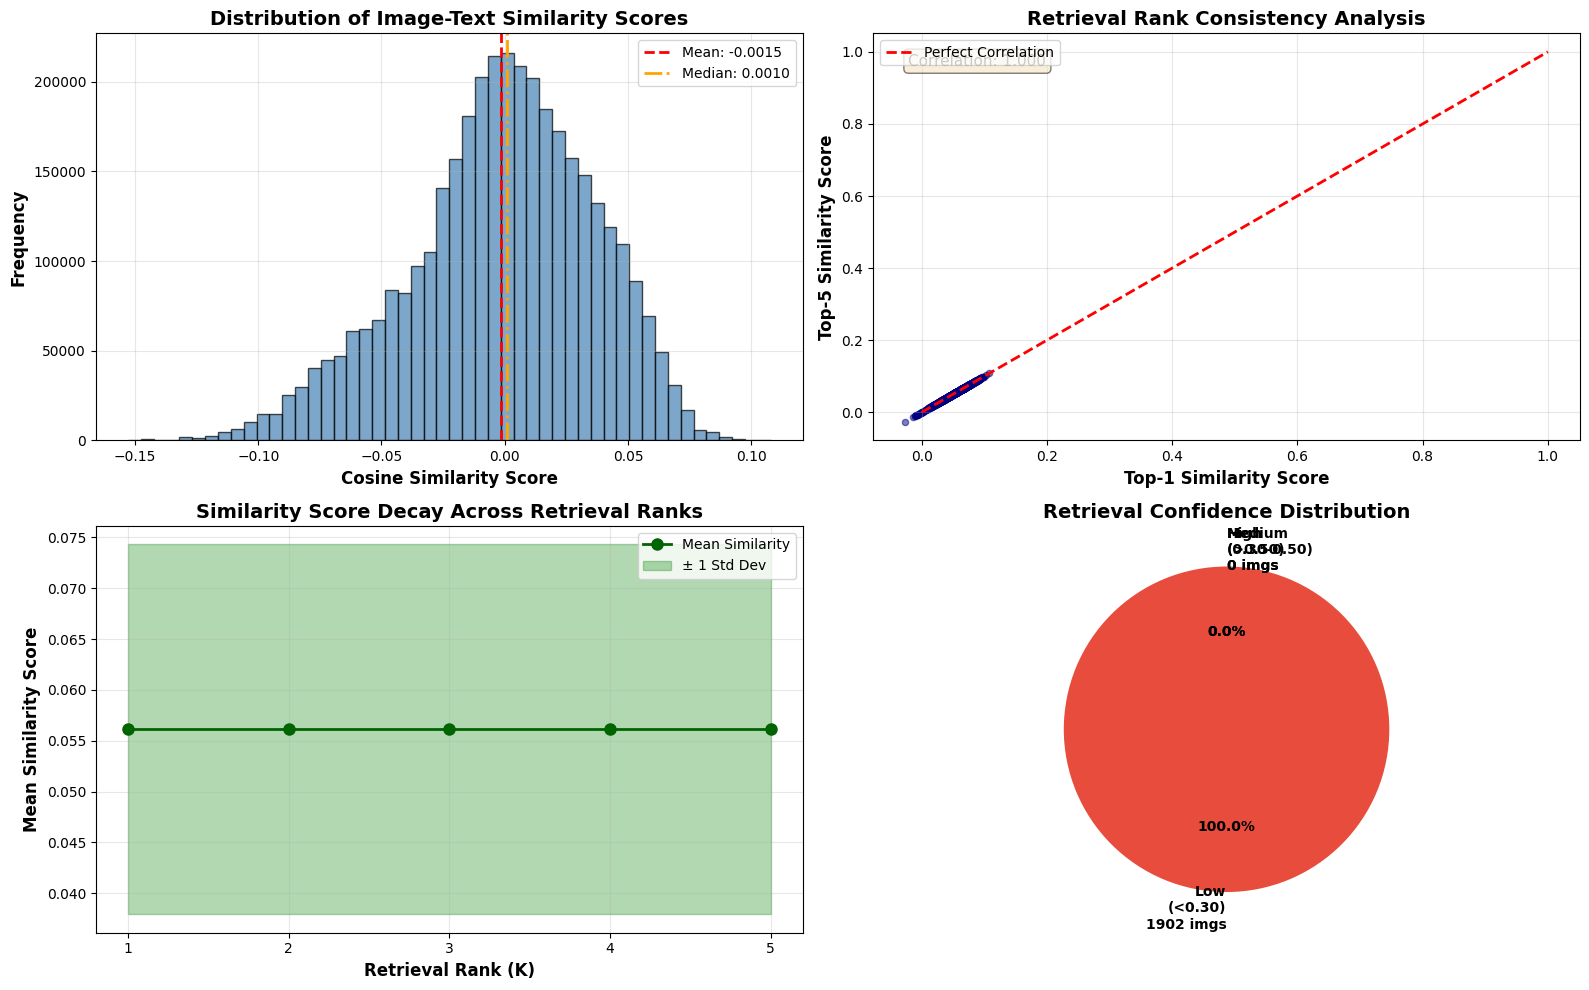

[SUCCESS] Evaluation visualizations generated


In [78]:
if similarity_matrix is not None and top_k_scores is not None:
    print("[PROCESS] Generating comprehensive evaluation visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Similarity score distribution
    all_scores = similarity_matrix.flatten().numpy()
    axes[0, 0].hist(all_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(all_scores.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {all_scores.mean():.4f}')
    axes[0, 0].axvline(np.median(all_scores), color='orange', linestyle='-.', linewidth=2,
                       label=f'Median: {np.median(all_scores):.4f}')
    axes[0, 0].set_xlabel('Cosine Similarity Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Distribution of Image-Text Similarity Scores', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Top-1 vs Top-5 correlation
    top1_scores = top_k_scores[:, 0].numpy()
    top5_scores = top_k_scores[:, 4].numpy()
    axes[0, 1].scatter(top1_scores, top5_scores, alpha=0.5, s=20, color='navy')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Correlation')
    
    correlation = np.corrcoef(top1_scores, top5_scores)[0, 1]
    axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                    transform=axes[0, 1].transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[0, 1].set_xlabel('Top-1 Similarity Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Top-5 Similarity Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Retrieval Rank Consistency Analysis', 
                         fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Similarity decay across ranks
    mean_scores_by_k = [top_k_scores[:, k].mean().item() for k in range(5)]
    std_scores_by_k = [top_k_scores[:, k].std().item() for k in range(5)]
    
    axes[1, 0].plot(range(1, 6), mean_scores_by_k, marker='o', linewidth=2, markersize=8,
                    color='darkgreen', label='Mean Similarity')
    axes[1, 0].fill_between(range(1, 6),
                           [m - s for m, s in zip(mean_scores_by_k, std_scores_by_k)],
                           [m + s for m, s in zip(mean_scores_by_k, std_scores_by_k)],
                           alpha=0.3, color='green', label='± 1 Std Dev')
    axes[1, 0].set_xlabel('Retrieval Rank (K)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Mean Similarity Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Similarity Score Decay Across Retrieval Ranks', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(range(1, 6))
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Confidence distribution
    confidence_data = [high_conf, medium_conf, low_conf]
    confidence_labels = [
        f'High\n(>0.50)\n{high_conf} imgs',
        f'Medium\n(0.30-0.50)\n{medium_conf} imgs',
        f'Low\n(<0.30)\n{low_conf} imgs'
    ]
    colors = ['#27ae60', '#f39c12', '#e74c3c']
    wedges, texts, autotexts = axes[1, 1].pie(
        confidence_data, 
        labels=confidence_labels,
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=90,
        textprops={'fontsize': 10, 'fontweight': 'bold'}
    )
    axes[1, 1].set_title('Retrieval Confidence Distribution', 
                         fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    eval_viz_path = os.path.join(OUTPUT_DIR, 'siglip_evaluation_metrics.png')
    plt.savefig(eval_viz_path, dpi=150, bbox_inches='tight')
    print(f"[SAVED] Evaluation visualization: {eval_viz_path}")
    plt.show()
    
    print("[SUCCESS] Evaluation visualizations generated")
    
else:
    print("[ERROR] Cannot generate visualizations: missing data")

## 18. Detailed Visualization: Sample Predictions with Herb Information

[PROCESS] Generating detailed prediction visualizations...


Test Sample 1/5 (Index: 1223)
[SAVED] Detailed visualization: /kaggle/working/siglip_results/siglip_prediction_1223.png


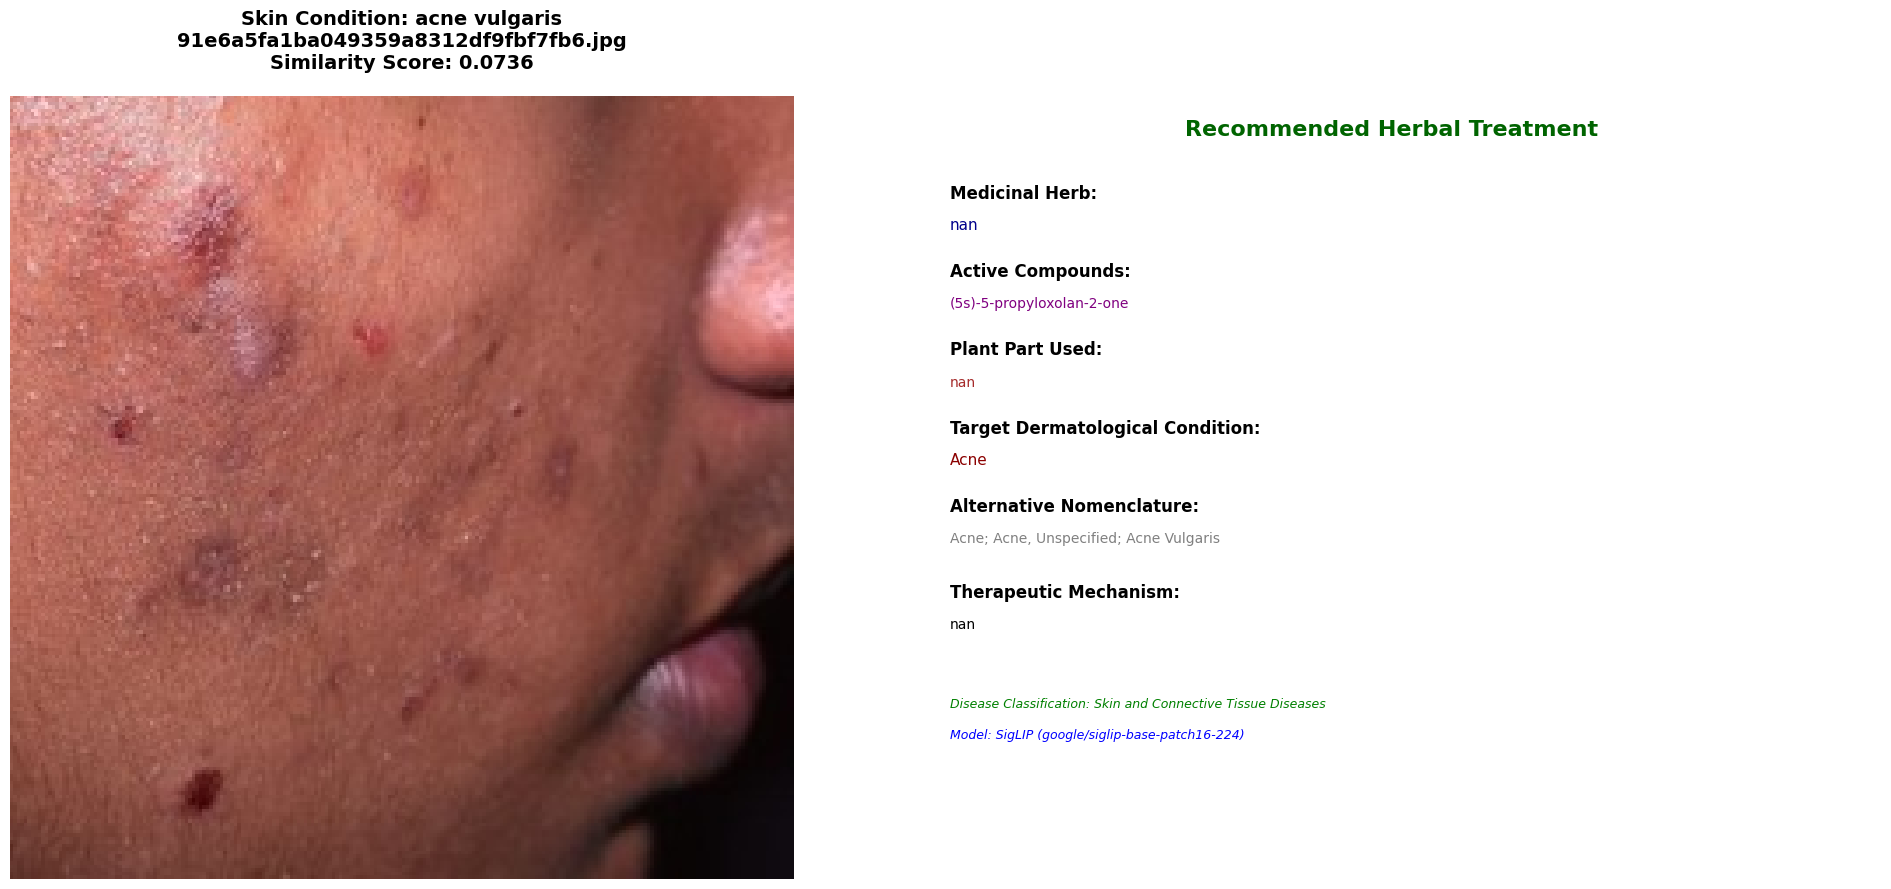


Test Sample 2/5 (Index: 111)
[SAVED] Detailed visualization: /kaggle/working/siglip_results/siglip_prediction_111.png


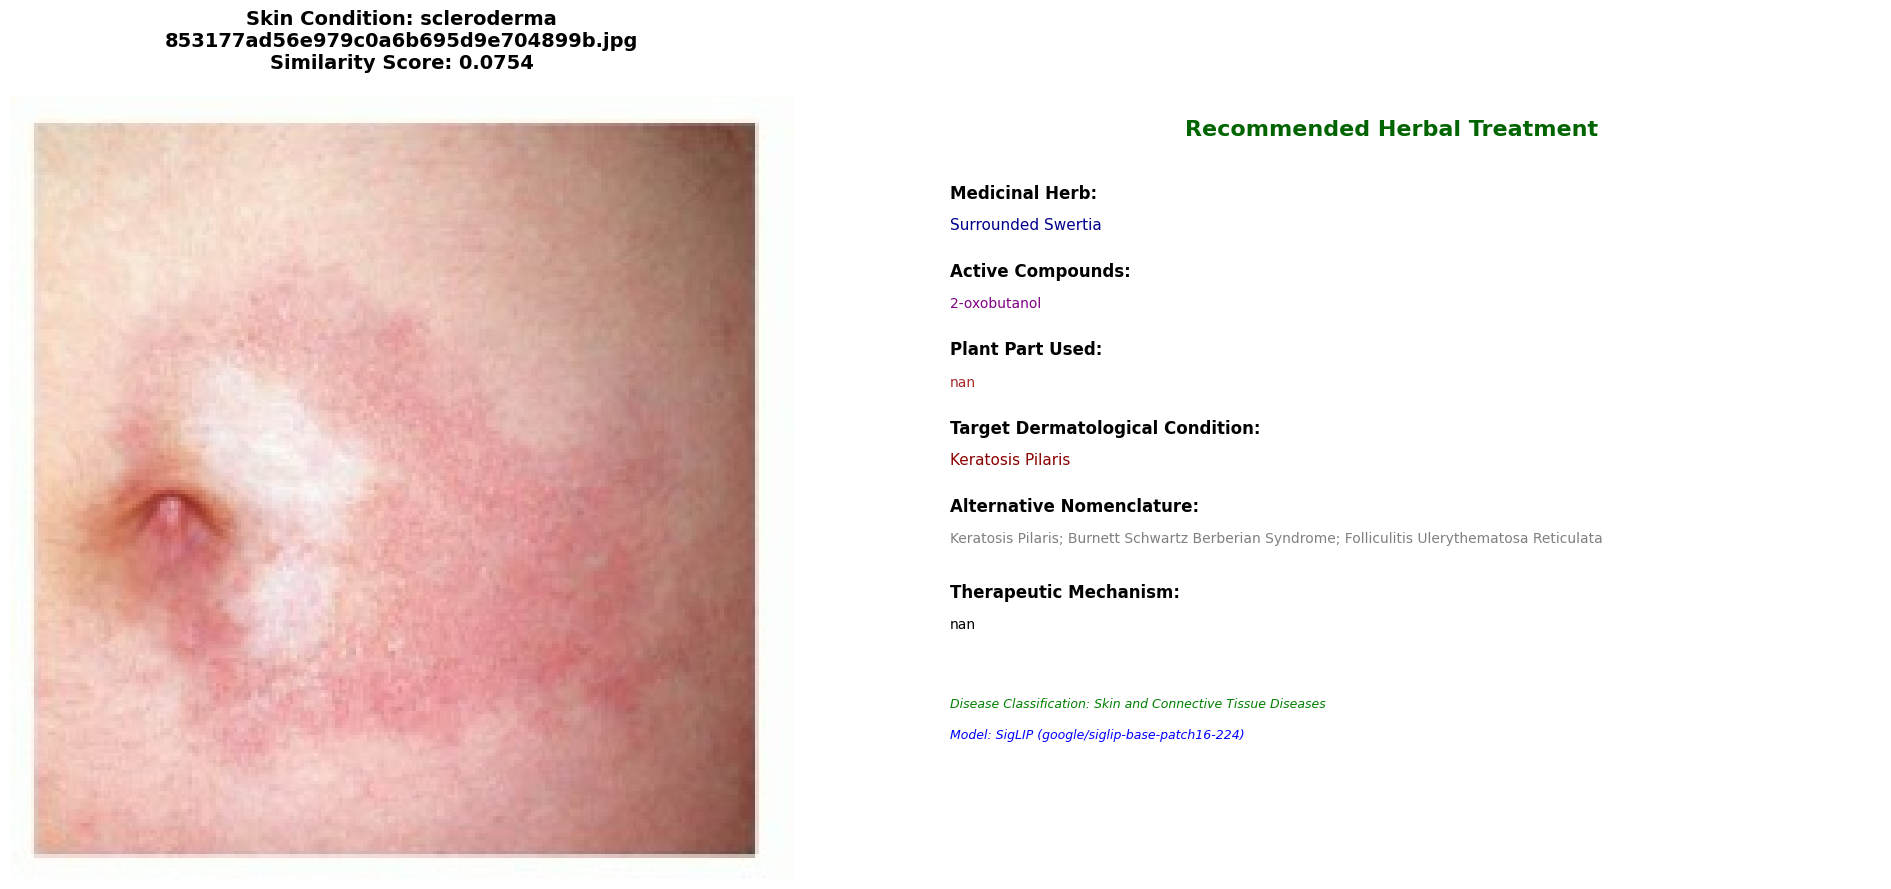


Test Sample 3/5 (Index: 554)
[SAVED] Detailed visualization: /kaggle/working/siglip_results/siglip_prediction_554.png


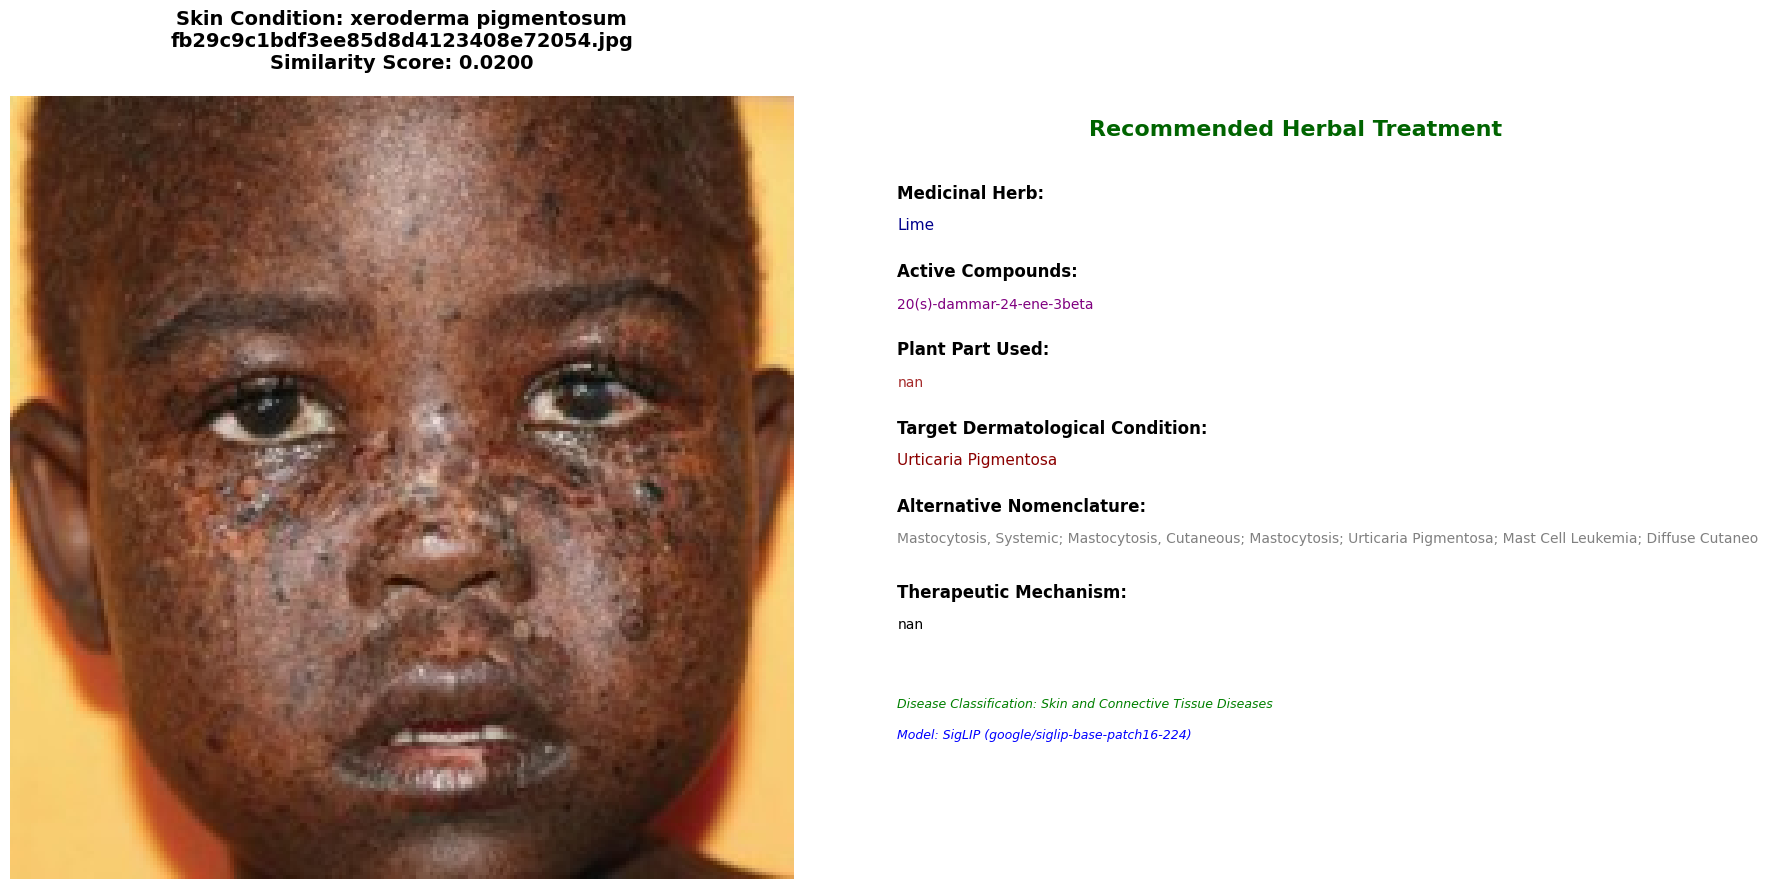


Test Sample 4/5 (Index: 526)
[SAVED] Detailed visualization: /kaggle/working/siglip_results/siglip_prediction_526.png


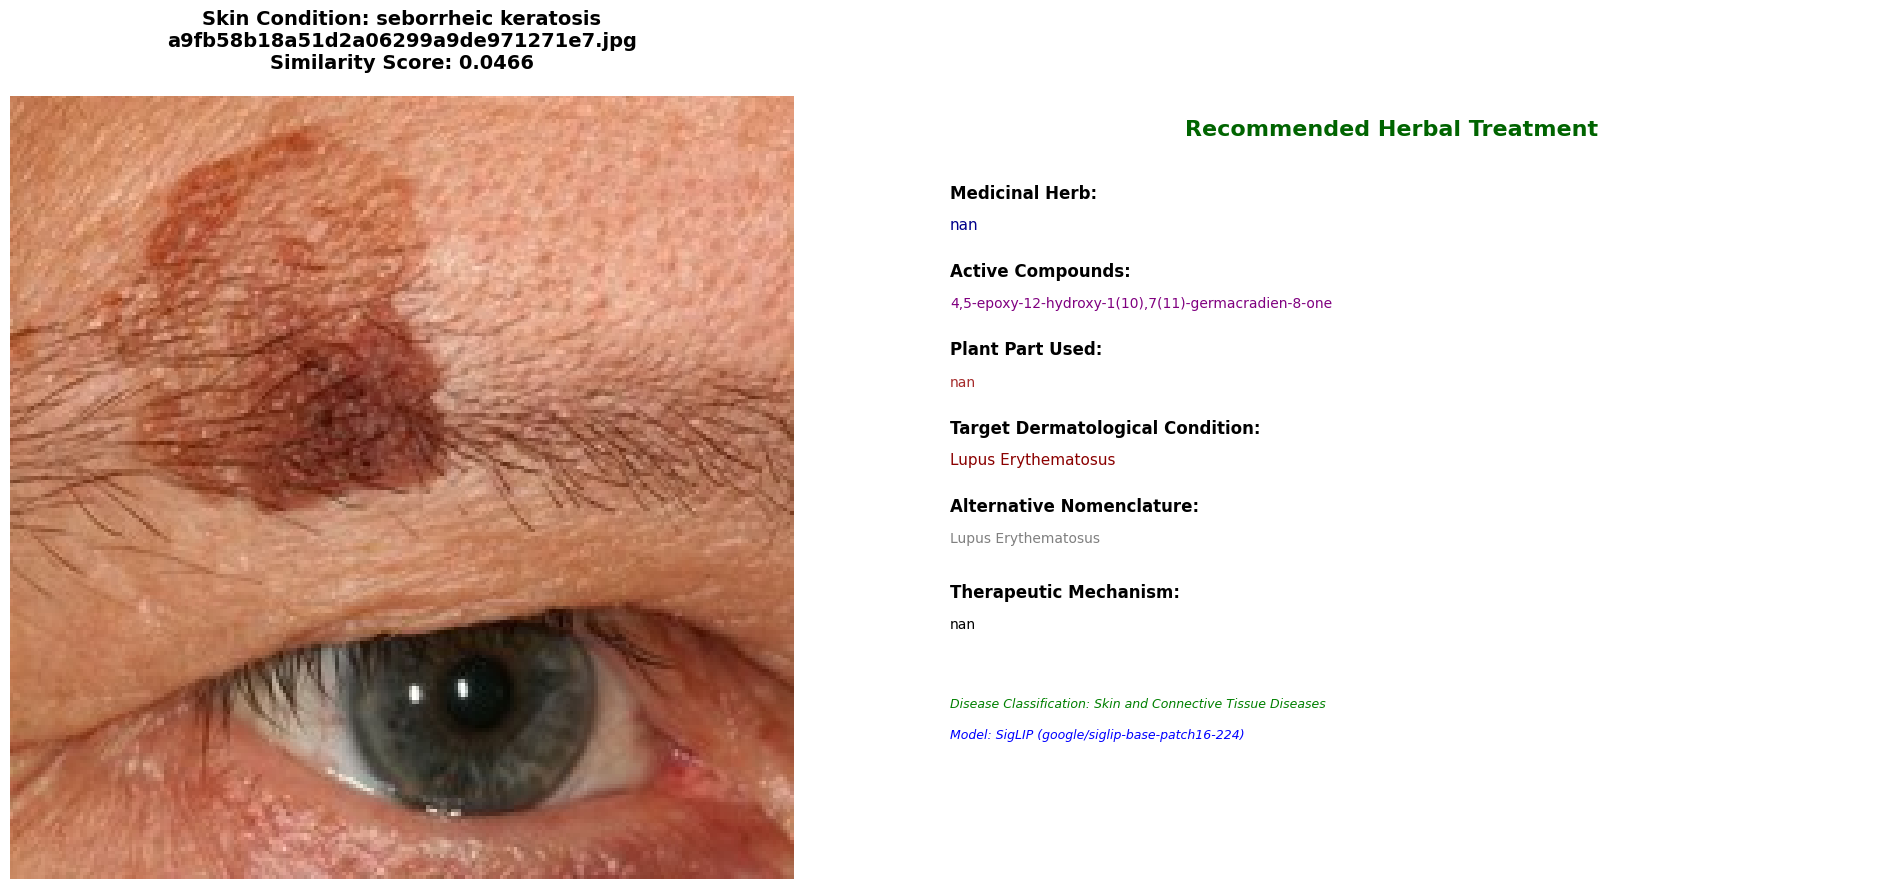


Test Sample 5/5 (Index: 1480)
[SAVED] Detailed visualization: /kaggle/working/siglip_results/siglip_prediction_1480.png


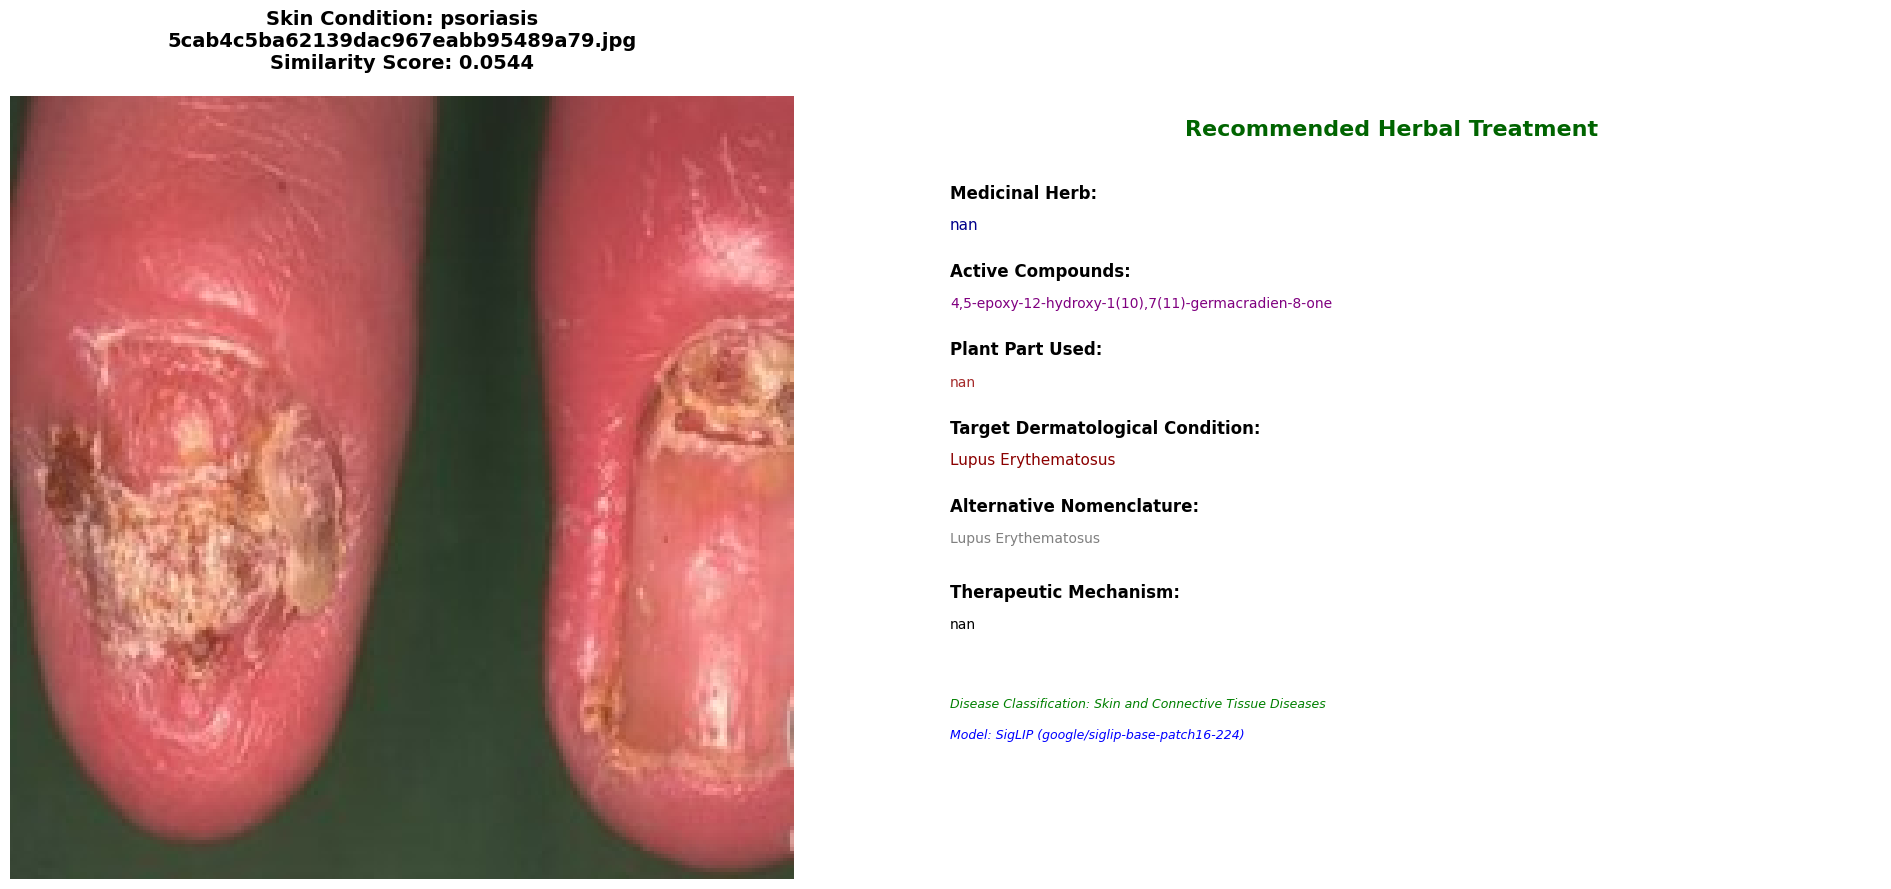

In [79]:
def visualize_detailed_prediction(test_idx: int):
    """
    Generate comprehensive visualization of herb recommendation for test image.
    
    Displays skin condition image alongside detailed herbal treatment information
    including herb name, active ingredients, plant parts used, therapeutic function,
    and disease information.
    
    Args:
        test_idx: Index of test sample to visualize
    """
    if test_idx >= len(test_df):
        print(f"[ERROR] Invalid index: {test_idx}")
        return
    
    test_row = test_df.iloc[test_idx]
    
    # Get top match
    top_idx = top_k_indices[test_idx, 0].item()
    top_score = top_k_scores[test_idx, 0].item()
    match_row = test_df.iloc[top_idx]
    
    # Load test image
    try:
        test_image = Image.open(test_row['image_path']).convert('RGB')
    except Exception as e:
        print(f"[ERROR] Failed to load image: {e}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # Display test skin condition image
    ax1.imshow(test_image)
    ax1.axis('off')
    title_text = f"Skin Condition: {test_row['label']}\n"
    title_text += f"{os.path.basename(test_row['image_path'])}\n"
    title_text += f"Similarity Score: {top_score:.4f}"
    ax1.set_title(title_text, fontsize=14, fontweight='bold', pad=20)
    
    # Display matched herb information
    ax2.axis('off')
    y = 0.95
    
    ax2.text(0.5, y, "Recommended Herbal Treatment",
            fontsize=16, fontweight='bold', ha='center', color='darkgreen')
    y -= 0.08
    
    # Herb name
    ax2.text(0.05, y, "Medicinal Herb:", fontsize=12, fontweight='bold')
    y -= 0.04
    herb_name = match_row.get('herb_name', 'Traditional herbal remedy')
    ax2.text(0.05, y, str(herb_name), fontsize=11, color='darkblue')
    y -= 0.06
    
    # Active ingredient
    if 'active_ingredient' in match_row and pd.notna(match_row['active_ingredient']):
        ax2.text(0.05, y, "Active Compounds:", fontsize=12, fontweight='bold')
        y -= 0.04
        ingredient = str(match_row['active_ingredient'])[:120]
        ax2.text(0.05, y, ingredient, fontsize=10, color='purple', wrap=True)
        y -= 0.06
    
    # Plant part used
    ax2.text(0.05, y, "Plant Part Used:", fontsize=12, fontweight='bold')
    y -= 0.04
    plant_part = match_row.get('plant_part_used', 'Various plant parts')
    ax2.text(0.05, y, str(plant_part)[:80], fontsize=10, color='brown')
    y -= 0.06
    
    # Target disease
    ax2.text(0.05, y, "Target Dermatological Condition:", fontsize=12, fontweight='bold')
    y -= 0.04
    disease = match_row.get('disease_name', match_row['label'])
    ax2.text(0.05, y, str(disease), fontsize=11, color='darkred')
    y -= 0.06
    
    # Disease aliases
    if 'disease_alias' in match_row and pd.notna(match_row['disease_alias']):
        ax2.text(0.05, y, "Alternative Nomenclature:", fontsize=12, fontweight='bold')
        y -= 0.04
        alias = str(match_row['disease_alias'])[:120]
        ax2.text(0.05, y, alias, fontsize=10, color='gray', wrap=True)
        y -= 0.07
    
    # Therapeutic function
    ax2.text(0.05, y, "Therapeutic Mechanism:", fontsize=12, fontweight='bold')
    y -= 0.04
    function = match_row.get('herb_function', 'Therapeutic properties for skin treatment')
    function_text = str(function)[:250]
    ax2.text(0.05, y, function_text, fontsize=10, wrap=True, color='black')
    y -= 0.10
    
    # Classification and model info
    ax2.text(0.05, y, "Disease Classification: Skin and Connective Tissue Diseases",
            fontsize=9, style='italic', color='green')
    y -= 0.04
    ax2.text(0.05, y, f"Model: SigLIP (google/siglip-base-patch16-224)",
            fontsize=9, style='italic', color='blue')
    
    plt.tight_layout()
    
    output_path = os.path.join(OUTPUT_DIR, f'siglip_prediction_{test_idx}.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"[SAVED] Detailed visualization: {output_path}")
    plt.show()

# Generate visualizations for sample test predictions
if top_k_indices is not None and test_df is not None:
    print("[PROCESS] Generating detailed prediction visualizations...\n")
    
    # Visualize 5 random test samples
    num_samples = min(5, len(test_df))
    random_indices = np.random.choice(len(test_df), size=num_samples, replace=False)
    
    for idx, test_idx in enumerate(random_indices, 1):
        print(f"\n{'='*70}")
        print(f"Test Sample {idx}/{num_samples} (Index: {test_idx})")
        print(f"{'='*70}")
        visualize_detailed_prediction(test_idx)
        
else:
    print("[ERROR] Cannot generate visualizations: missing required data")

## 19. Per-Disease Performance Analysis

[PROCESS] Analyzing per-disease retrieval performance...

PER-DISEASE RETRIEVAL PERFORMANCE ANALYSIS

Top 10 Diseases by Average Retrieval Similarity:
Rank   Disease                                  Mean       Std        Count   
------------------------------------------------------------------------------------------
1      acne vulgaris                            0.0739     0.0148     101     
2      acne                                     0.0672     0.0215     55      
3      porokeratosis of mibelli                 0.0663     0.0119     23      
4      pustular psoriasis                       0.0650     0.0120     16      
5      actinic keratosis                        0.0647     0.0142     53      
6      rosacea                                  0.0636     0.0135     31      
7      pityriasis rubra pilaris                 0.0619     0.0176     83      
8      folliculitis                             0.0610     0.0128     103     
9      lupus erythematosus                     

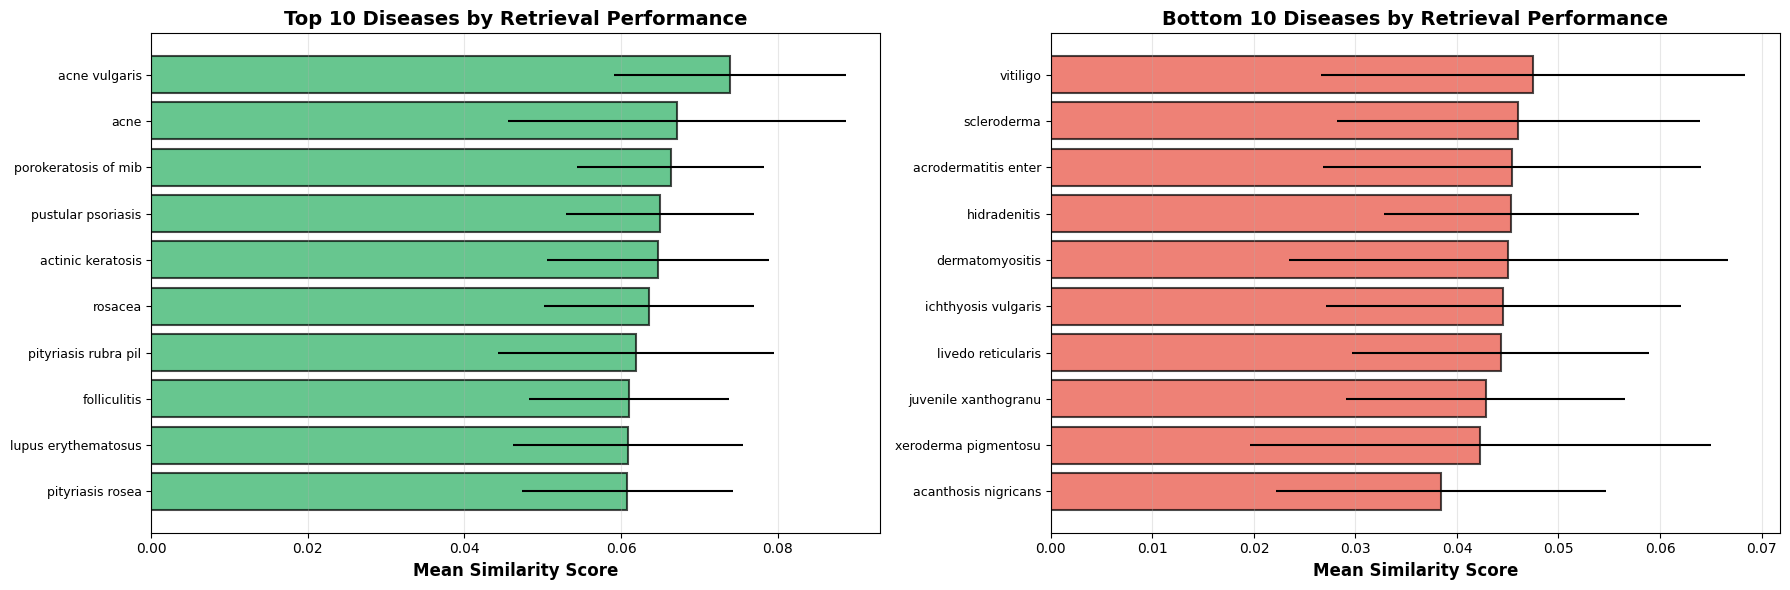

[SAVED] Per-disease statistics: /kaggle/working/siglip_results/per_disease_statistics.csv



In [80]:
if top_k_scores is not None and test_df is not None:
    print("[PROCESS] Analyzing per-disease retrieval performance...\n")
    
    # Aggregate scores by disease
    disease_scores = {}
    for i in range(len(test_df)):
        disease = test_df.iloc[i]['label']
        top1_score = top_k_scores[i, 0].item()
        
        if disease not in disease_scores:
            disease_scores[disease] = []
        disease_scores[disease].append(top1_score)
    
    # Compute statistics per disease
    disease_stats = {}
    for disease, scores in disease_scores.items():
        disease_stats[disease] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'count': len(scores),
            'min': np.min(scores),
            'max': np.max(scores)
        }
    
    # Sort by average retrieval performance
    sorted_diseases = sorted(disease_stats.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    print(f"{'='*90}")
    print("PER-DISEASE RETRIEVAL PERFORMANCE ANALYSIS")
    print(f"{'='*90}")
    
    print(f"\nTop 10 Diseases by Average Retrieval Similarity:")
    print(f"{'Rank':<6} {'Disease':<40} {'Mean':<10} {'Std':<10} {'Count':<8}")
    print(f"{'-'*90}")
    for i, (disease, stats) in enumerate(sorted_diseases[:10], 1):
        disease_name = disease[:38] if len(disease) > 38 else disease
        print(f"{i:<6d} {disease_name:<40} {stats['mean']:<10.4f} {stats['std']:<10.4f} {stats['count']:<8d}")
    
    print(f"\nBottom 10 Diseases by Average Retrieval Similarity:")
    print(f"{'Rank':<6} {'Disease':<40} {'Mean':<10} {'Std':<10} {'Count':<8}")
    print(f"{'-'*90}")
    for i, (disease, stats) in enumerate(sorted_diseases[-10:], 1):
        disease_name = disease[:38] if len(disease) > 38 else disease
        print(f"{i:<6d} {disease_name:<40} {stats['mean']:<10.4f} {stats['std']:<10.4f} {stats['count']:<8d}")
    
    # Visualize top and bottom performing diseases
    print(f"\n[PROCESS] Generating per-disease performance visualization...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Top 10 diseases
    top_10_diseases = sorted_diseases[:10]
    top_10_names = [d[0][:20] for d in top_10_diseases]
    top_10_means = [d[1]['mean'] for d in top_10_diseases]
    top_10_stds = [d[1]['std'] for d in top_10_diseases]
    
    y_pos = np.arange(len(top_10_names))
    ax1.barh(y_pos, top_10_means, xerr=top_10_stds, color='#27ae60', alpha=0.7, 
             edgecolor='black', linewidth=1.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_10_names, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Mean Similarity Score', fontsize=12, fontweight='bold')
    ax1.set_title('Top 10 Diseases by Retrieval Performance', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Bottom 10 diseases
    bottom_10_diseases = sorted_diseases[-10:]
    bottom_10_names = [d[0][:20] for d in bottom_10_diseases]
    bottom_10_means = [d[1]['mean'] for d in bottom_10_diseases]
    bottom_10_stds = [d[1]['std'] for d in bottom_10_diseases]
    
    y_pos = np.arange(len(bottom_10_names))
    ax2.barh(y_pos, bottom_10_means, xerr=bottom_10_stds, color='#e74c3c', alpha=0.7,
             edgecolor='black', linewidth=1.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(bottom_10_names, fontsize=9)
    ax2.invert_yaxis()
    ax2.set_xlabel('Mean Similarity Score', fontsize=12, fontweight='bold')
    ax2.set_title('Bottom 10 Diseases by Retrieval Performance', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    disease_perf_path = os.path.join(OUTPUT_DIR, 'per_disease_performance.png')
    plt.savefig(disease_perf_path, dpi=150, bbox_inches='tight')
    print(f"[SAVED] Per-disease performance visualization: {disease_perf_path}")
    plt.show()
    
    # Save per-disease statistics
    disease_stats_df = pd.DataFrame.from_dict(disease_stats, orient='index')
    disease_stats_df = disease_stats_df.sort_values('mean', ascending=False)
    disease_stats_path = os.path.join(OUTPUT_DIR, 'per_disease_statistics.csv')
    disease_stats_df.to_csv(disease_stats_path)
    print(f"[SAVED] Per-disease statistics: {disease_stats_path}")
    
    print(f"\n{'='*90}")
    
else:
    print("[ERROR] Cannot perform per-disease analysis: missing data")

## 20. Summary Statistics and Final Report

In [83]:

print(" " * 25 + "SIGLIP REPORT")


print("\n[MODEL CONFIGURATION]")
print(f"  Model Architecture: SigLIP (Sigmoid Loss for Language-Image Pre-training)")
print(f"  Model Variant: {MODEL_NAME}")
print(f"  Device: {device.upper()}")
if model is not None:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total Parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    print(f"  Trainable Parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")

print("\n[DATASET STATISTICS]")
if dataset_df is not None:
    print(f"  Total Samples (Merged): {len(dataset_df):,}")
if train_df is not None and test_df is not None:
    print(f"  Training Samples: {len(train_df):,} (70%)")
    print(f"  Testing Samples: {len(test_df):,} (30%)")
    print(f"  Unique Diseases (Train): {train_df['label'].nunique()}")
    print(f"  Unique Diseases (Test): {test_df['label'].nunique()}")
    print(f"  Disease Scope: Skin and Connective Tissue Diseases Only")

print("\n[TRAINING CONFIGURATION]")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Warmup Steps: {WARMUP_STEPS}")
print(f"  Gradient Clipping: {GRADIENT_CLIP}")
print(f"  Optimizer: AdamW")
print(f"  Loss Function: SigLIP Sigmoid Contrastive Loss")

if training_history is not None:
    history_df = pd.DataFrame(training_history)
    if len(history_df) > 0:
        print("\n[TRAINING RESULTS]")
        print(f"  Initial Training Loss: {history_df['train_loss'].iloc[0]:.4f}")
        print(f"  Final Training Loss: {history_df['train_loss'].iloc[-1]:.4f}")
        print(f"  Loss Reduction: {(1 - history_df['train_loss'].iloc[-1]/history_df['train_loss'].iloc[0])*100:.2f}%")
    else:
        print("\n[TRAINING RESULTS]")
        print("  Training not yet executed - please run the training cell (Section 13)")

print("\n[EVALUATION METRICS - TEST SET]")
if 'recall_at_1' in locals():
    print(f"  Retrieval Performance:")
    print(f"    Recall@1: {recall_at_1:.4f} ({recall_at_1*100:.2f}%)")
    print(f"    Recall@3: {recall_at_3:.4f} ({recall_at_3*100:.2f}%)")
    print(f"    Recall@5: {recall_at_5:.4f} ({recall_at_5*100:.2f}%)")
    print(f"  Ranking Quality:")
    print(f"    Mean Reciprocal Rank: {mrr:.4f}")
    print(f"    MAP@5: {map_at_5:.4f}")
    print(f"    NDCG@5: {ndcg_at_5:.4f}")

if top_k_scores is not None:
    print(f"  Similarity Scores:")
    print(f"    Top-1 Mean: {top_k_scores[:, 0].mean():.4f}")
    print(f"    Top-5 Mean: {top_k_scores[:, 4].mean():.4f}")

if similarity_matrix is not None:
    print(f"    Overall Mean: {similarity_matrix.mean():.4f}")
    print(f"    Overall Std: {similarity_matrix.std():.4f}")

print("\n[OUTPUT FILES]")
print(f"  Results Directory: {OUTPUT_DIR}")
print(f"  Embeddings Directory: {EMBEDDING_DIR}")
print(f"  Checkpoints Directory: {CHECKPOINT_DIR}")
print(f"\n  Generated Files:")
print(f"    - siglip_train_split.csv")
print(f"    - siglip_test_split.csv")
print(f"    - evaluation_metrics.json")
print(f"    - training_history.csv")
print(f"    - test_image_embeddings.pt")
print(f"    - test_text_embeddings.pt")
print(f"    - similarity_matrix.pt")
print(f"    - siglip_evaluation_metrics.png")
print(f"    - per_disease_performance.png")
print(f"    - training_progress.png")
print(f"    - siglip_prediction_*.png (sample visualizations)")

print("\n[PROJECT STATUS]")
print(f"  Data Loading: {'✓ Completed' if dataset_df is not None else '✗ Failed'}")
print(f"  Train-Test Split: {'✓ Completed' if train_df is not None else '✗ Failed'}")
print(f"  Model Loading: {'✓ Completed' if model is not None else '✗ Failed'}")
print(f"  Training: {'✓ Completed' if training_history is not None else '✗ Skipped'}")
print(f"  Evaluation: {'✓ Completed' if similarity_matrix is not None else '✗ Failed'}")
print(f"  Visualization: {'✓ Completed' if top_k_scores is not None else '✗ Failed'}")


print(" " * 20 + "SIGLIP EXECUTION COMPLETED")


                         SIGLIP REPORT

[MODEL CONFIGURATION]
  Model Architecture: SigLIP (Sigmoid Loss for Language-Image Pre-training)
  Model Variant: google/siglip-base-patch16-224
  Device: CUDA
  Total Parameters: 203,155,970 (203.16M)
  Trainable Parameters: 203,155,970 (203.16M)

[DATASET STATISTICS]
  Total Samples (Merged): 6,337
  Training Samples: 4,435 (70%)
  Testing Samples: 1,902 (30%)
  Unique Diseases (Train): 36
  Unique Diseases (Test): 36
  Disease Scope: Skin and Connective Tissue Diseases Only

[TRAINING CONFIGURATION]
  Learning Rate: 1e-05
  Weight Decay: 0.01
  Batch Size: 32
  Number of Epochs: 5
  Warmup Steps: 100
  Gradient Clipping: 1.0
  Optimizer: AdamW
  Loss Function: SigLIP Sigmoid Contrastive Loss

[TRAINING RESULTS]
  Training not yet executed - please run the training cell (Section 13)

[EVALUATION METRICS - TEST SET]
  Retrieval Performance:
    Recall@1: 0.0016 (0.16%)
    Recall@3: 0.0047 (0.47%)
    Recall@5: 0.0084 (0.84%)
  Ranking Quality: